# Preprocess CT Scans

## 1. Libraries

In [28]:
#########################################################################
# 01. Libraries

import os
import pandas as pd
import numpy as np
import random
np.random.seed(12)

import matplotlib.pyplot as plt
import glob
import cv2

import time
from tqdm import tqdm

import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation, color
import pydicom
import imageio
from joblib import parallel_backend, Parallel, delayed
import PIL

#########################################################################

## 2. Global Variables

In [18]:
#########################################################################
# 02. Global Variables

path = '../01_Data/'

path_imgs_train = path + '/train/'
path_imgs_test = path + '/test/'

#########################################################################

## 3. Load Data & Preprocess Data

In [19]:
#########################################################################
# 03. Load Data & Preprocess Data

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

print(f'1.1 -> There are {df_train.Patient.unique().shape[0]} train unique patients')
print(f'1.2 -> There are {df_test.Patient.unique().shape[0]} test unique patients')

train_paths = glob.glob(path_imgs_train + '*')
test_paths = glob.glob(path_imgs_test + '*')
      
print(f'No. of Train Images : {len(train_paths)}')
print(f'No. of Test Images : {len(test_paths)}')
      
unique_train_patients = df_train.Patient.unique()
unique_test_patients = df_test.Patient.unique()

dict_train_patients_paths = {patient: path_imgs_train + patient + '/' for patient in unique_train_patients}
dict_test_patients_paths = {patient: path_imgs_test + patient + '/' for patient in unique_test_patients}

for patient in tqdm(dict_train_patients_paths):
    list_files = os.listdir(dict_train_patients_paths[patient])
    list_files = [dict_train_patients_paths[patient] + file for file in list_files]
    dict_train_patients_paths[patient] = list_files
    
for patient in tqdm(dict_test_patients_paths):
    list_files = os.listdir(dict_test_patients_paths[patient])
    list_files = [dict_test_patients_paths[patient] + file for file in list_files]
    dict_test_patients_paths[patient] = list_files
    
    
#########################################################################

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5012.31it/s]

1.1 -> There are 176 train unique patients
1.2 -> There are 5 test unique patients
No. of Train Images : 176
No. of Test Images : 5


## 4. Global Functions

In [20]:
#########################################################################
# 04. Global Functions

def loadSlices(patient_files):
    slices = [pydicom.read_file(s) for s in patient_files]
    slices.sort(key = lambda x: float(x.InstanceNumber))
        
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            slice_thickness = slices[0].SliceThickness
            slices[0].RescaleIntercept = 1024
    
    if slice_thickness == 0:
        slice_thickness = 1
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


def getPixelsHu(patient_scans):
    patient_images = []
    for s in patient_scans:
        if s.Columns != s.Rows:
            crop_size = 512
            s_crop_img = imCropCenter(s.pixel_array, crop_size, crop_size)
            patient_images.append(s_crop_img)
        else:
            patient_images.append(s.pixel_array)

    patient_images = np.asarray(patient_images).astype(np.int16)

    # The intercept is usually -1024, so air is approximately 0
    patient_images[patient_images == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = patient_scans[0].RescaleIntercept
    slope = patient_scans[0].RescaleSlope
        
    if slope != 1:
        patient_images = slope * patient_images.astype(np.float64)
        patient_images = patient_images.astype(np.int16)

    patient_images += np.int16(intercept)
    patient_images = np.clip(patient_images, -2048, 3284)
    return np.array(patient_images, dtype=np.int16)


def plotHistogramPixelesHu(patient_images):
    plt.hist(patient_images.flatten(), bins=50, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel
    plt.show()
    

def plotSampleStack(stack, rows=6, cols=6, start_with=10, show_every=3, figsize=(12,12)):
    fig,ax = plt.subplots(rows,cols,figsize=figsize)
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()


def resampleImages(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = [float(scan[0].SliceThickness), 
                float(scan[0].PixelSpacing[0]), 
                float(scan[0].PixelSpacing[1])]

    spacing = np.array(spacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, spacing


def generateMarkers(image):
    """
    Generates markers for a given image.
    
    Parameters: image
    
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    # Creation of the External Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    # Creation of the Watershed Marker
    marker_watershed = np.zeros(image.shape, dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed


def seperateLungs(image, n_iters=2):
    """
    Segments lungs using various techniques.
    
    Parameters: image (Scan image)
    
    Returns: 
        - Segmented Lung
        - Lung Filter
        - Outline Lung
        - Watershed Lung
        - Sobel Gradient
    """
    marker_internal, marker_external, marker_watershed = generateMarkers(image)
    
    
    '''
    Creation of Sobel Gradient
    '''
    
    # Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    
    '''
    Using the watershed algorithm
    
    
    We pass the image convoluted by sobel operator and the watershed marker
    to morphology.watershed and get a matrix matrix labeled using the 
    watershed segmentation algorithm.
    '''
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    '''
    Reducing the image to outlines after Watershed algorithm
    '''
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    
    '''
    Black Top-hat Morphology:
    
    The black top hat of an image is defined as its morphological closing
    minus the original image. This operation returns the dark spots of the
    image that are smaller than the structuring element. Note that dark 
    spots in the original image are bright spots after the black top hat.
    '''
    
    # Structuring element used for the filter
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, n_iters)
    
    # Perform Black Top-hat filter
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    '''
    Generate lung filter using internal marker and outline.
    '''
    lungfilter = np.bitwise_or(marker_internal, outline)
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    '''
    Segment lung using lungfilter and the image.
    '''
    segmented = np.where(lungfilter == 1, image, -2000*np.ones(image.shape))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient


def imCropCenter(img, w, h):
    img = PIL.Image.fromarray(img)
    img_width, img_height = img.size
    left, right = (img_width - w) / 2, (img_width + w) / 2
    top, bottom = (img_height - h) / 2, (img_height + h) / 2
    left, top = round(max(0, left)), round(max(0, top))
    right, bottom = round(min(img_width - 0, right)), round(min(img_height - 0, bottom))
    return np.asarray(img.crop((left, top, right, bottom)))
     
    
def imCropAround(img, xc, yc, w, h):
    img_width, img_height = img.size  # Get dimensions
    left, right = xc - w / 2, xc + w / 2
    top, bottom = yc - h / 2, yc + h / 2
    left, top = round(max(0, left)), round(max(0, top))
    right, bottom = round(min(img_width - 0, right)), round(min(img_height - 0, bottom))
    return img.crop((left, top, right, bottom))

#########################################################################

## 5. Lookup

There are 260 patient slices for patient ID00329637202285906759848


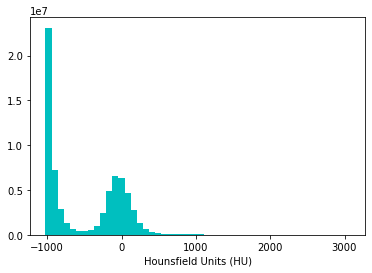

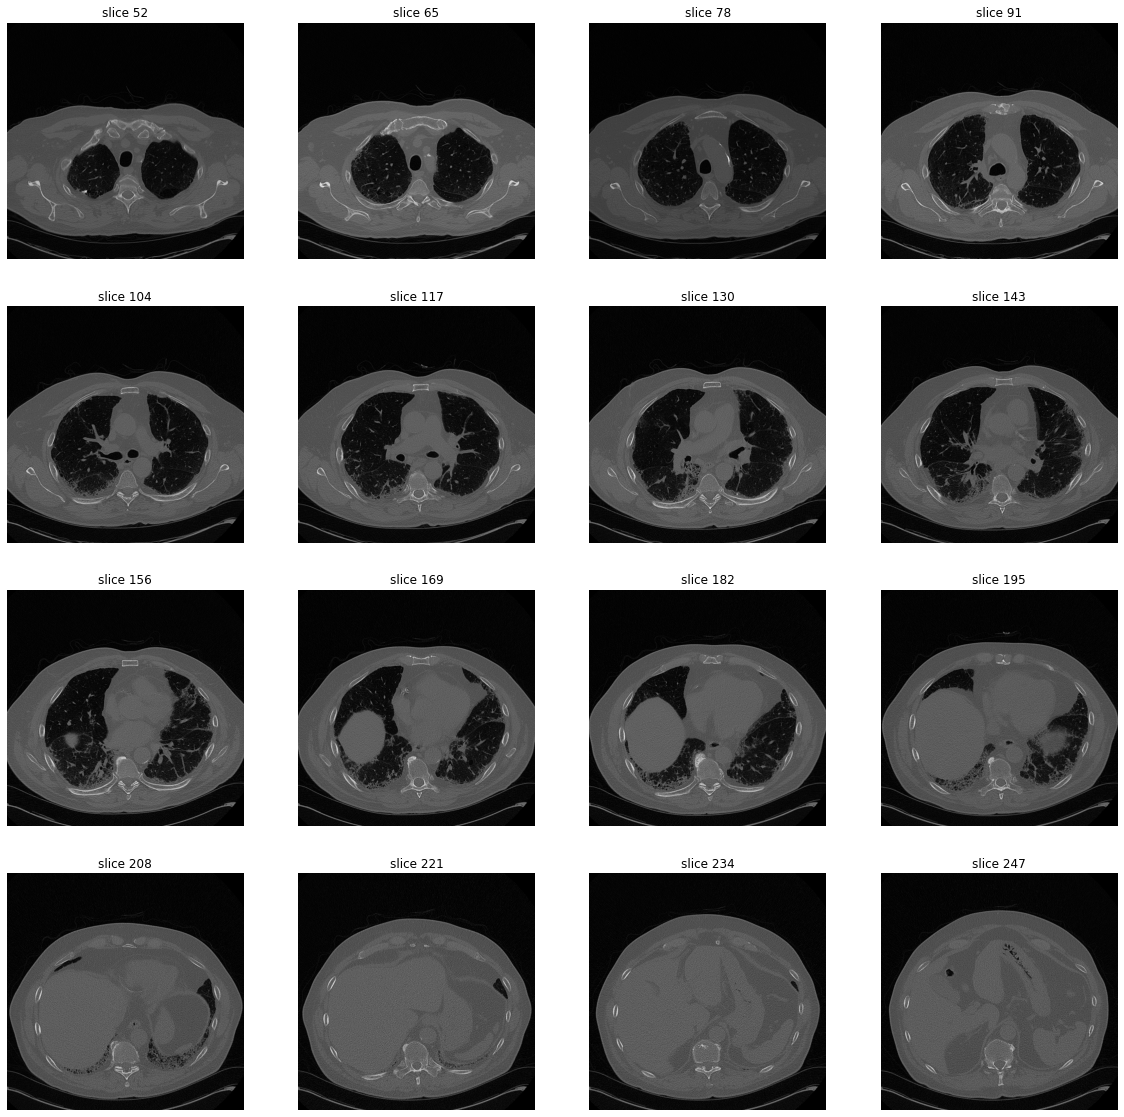

In [23]:
#########################################################################
# 05. Lookup

patient = np.random.choice(unique_train_patients)
# patient = 'ID00267637202270790561585' # worst patient
# patient = 'ID00219637202258203123958' # best patient
patient_files = dict_train_patients_paths[patient]
patient_slices = loadSlices(patient_files)
patient_images = getPixelsHu(patient_slices)
print(f'There are {len(patient_files)} patient slices for patient {patient}')

plotHistogramPixelesHu(patient_images)
plotSampleStack(patient_images, rows=4, cols=4, 
                start_with=int(patient_images.shape[0]*0.2),
                show_every=int((patient_images.shape[0] - int(patient_images.shape[0]*0.2)) / (4*4)),
                figsize=(20, 20))

#########################################################################

## 6. Masking

Patient: ID00329637202285906759848
Shape before resampling	 (260, 512, 512)
Shape after resampling	 (260, 385, 385)


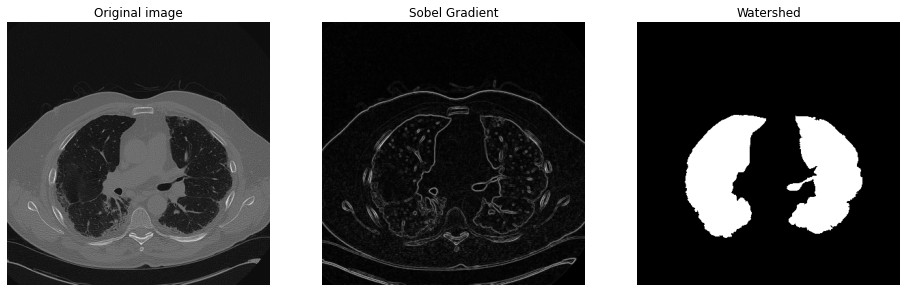

(-0.5, 384.5, 384.5, -0.5)

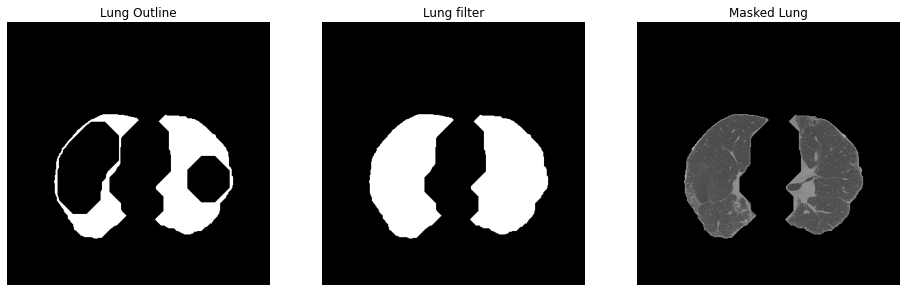

In [24]:
#########################################################################
# 06. Masking

print(f'Patient: {patient}')
patient_files = dict_train_patients_paths[patient]
patient_slices = loadSlices(patient_files)
patient_images = getPixelsHu(patient_slices)

imgs_after_resamp, spacing = resampleImages(patient_images, patient_slices, [1,1,1])
print ("Shape before resampling\t", patient_images.shape)
print ("Shape after resampling\t", imgs_after_resamp.shape)


img = imgs_after_resamp[125]
img_mask, img_lungfilter, img_outline, img_watershed, img_sobel_gradient = seperateLungs(img, n_iters=10)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (16, 16))

ax1.imshow(imgs_after_resamp[125], cmap='gray')
ax1.set_title("Original image")
ax1.axis('off')

ax2.imshow(img_sobel_gradient, cmap='gray')
ax2.set_title("Sobel Gradient")
ax2.axis('off')

ax3.imshow(img_watershed, cmap='gray')
ax3.set_title("Watershed")
ax3.axis('off')

plt.show()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (16, 16))

ax1.imshow(img_outline, cmap='gray')
ax1.set_title("Lung Outline")
ax1.axis('off')

ax2.imshow(img_lungfilter, cmap='gray')
ax2.set_title("Lung filter")
ax2.axis('off')

ax3.imshow(img_mask, cmap='gray')
ax3.set_title("Masked Lung")
ax3.axis('off')
#########################################################################

## 7. Save Images

In [26]:
#########################################################################
# 07. Save Images
 
def saveMasks(patient, dict_paths, path, center_crop_size=80):
    try:
        patient_files = dict_paths[patient]
        patient_files = sorted(patient_files, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))
        patient_slices = loadSlices(patient_files)
        patient_images = getPixelsHu(patient_slices)
        imgs_after_resamp, spacing = resampleImages(patient_images, patient_slices, [1,1,1])
        patient_imgs = []
        for idx in range(imgs_after_resamp.shape[0]):
            patient_crop_img = imCropCenter(imgs_after_resamp[idx], 320, 320)
            patient_segmented, _, _, _, _ = seperateLungs(patient_crop_img, n_iters=10)
            patient_imgs.append(patient_segmented)
            
        patient_imgs = np.asarray(patient_imgs)
        file_name = patient + '_imgs_' + '.npy'
        if not os.path.exists(path + patient + '/'):
            os.mkdir(path + patient + '/')
        file_output = path + patient + '/' + file_name
        np.save(file_output, patient_imgs)
    except:
        print(f'Patient {patient} failed')
        pass
    
def saveScans(patient, dict_paths, path, center_crop_size=80):
    try:
        patient_files = dict_paths[patient]
        patient_files = sorted(patient_files, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))
        patient_slices = loadSlices(patient_files)
        patient_images = getPixelsHu(patient_slices)
        imgs_after_resamp, spacing = resampleImages(patient_images, patient_slices, [1,1,1])
        patient_imgs = []
        for idx in range(imgs_after_resamp.shape[0]):
            patient_crop_img = imCropCenter(imgs_after_resamp[idx], 320, 320)
            patient_imgs.append(patient_crop_img)
            
        patient_imgs = np.asarray(patient_imgs)
        file_name = patient + '_imgs_' + '.npy'
        if not os.path.exists(path + patient + '/'):
            os.mkdir(path + patient + '/')
        file_output = path + patient + '/' + file_name
        np.save(file_output, patient_imgs)
    except:
        print(f'Patient {patient} failed')
        pass


#########################################################################

## 8. Export Masks and Preprocessed Images

In [27]:
#########################################################################

path_out = path + './train_masks/'
if not os.path.exists(path_out):
    os.mkdir(path_out)
path_out = path + './test_masks/'
if not os.path.exists(path):
    os.mkdir(path)

num_processors = int(int(os.environ['NUMBER_OF_PROCESSORS']) * 0.8) + 1

with parallel_backend('threading', n_jobs=num_processors):
    Parallel()(delayed(saveMasks)(patient, dict_train_patients_paths, path=path_out) for patient in unique_train_patients)
with parallel_backend('threading', n_jobs=num_processors):
    Parallel()(delayed(saveMasks)(patient, dict_test_patients_paths, path=path_out) for patient in unique_test_patients)
    
path_out = path + './train_imgs/'
if not os.path.exists(path_out):
    os.mkdir(path_out)
path_out = path + './test_imgs/'
if not os.path.exists(path):
    os.mkdir(path)

with parallel_backend('threading', n_jobs=num_processors):
    Parallel()(delayed(saveScans)(patient, dict_train_patients_paths, path=path_out) for patient in unique_train_patients)
with parallel_backend('threading', n_jobs=num_processors):
    Parallel()(delayed(saveScans)(patient, dict_test_patients_paths, path=path_out) for patient in unique_test_patients)
    
    #########################################################################

Patient ID00011637202177653955184 failed


KeyboardInterrupt: 

## 9. References

1. **Image Processing** - https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

2. **Lung Segmentation** - https://medium.com/@hengloose/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed

3. **Watershed masking algorithm** - https://en.wikipedia.org/wiki/Watershed_(image_processing)